# Imputing data

In [10]:
import pandas as pd  
import numpy as np
import warnings 
import math
import statsmodels as sm
warnings.simplefilter('ignore')

import seaborn as sns
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)
import matplotlib.pyplot as plt


# import custom functions
import sys
sys.path.append("../")
from projectname import custom_funcs


In [11]:
# load full dataset 
NCDB = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv")


In [12]:
#  filter for selected features 
NCDB = NCDB[['AGE', 'SEX',
               'lymph_vasc_invasion', 'tumor_depth',
              'metastasis']]
print("Total cases: {}".format(NCDB.shape[0]))

Total cases: 14948


#### first, filter out anyone missing outcome - need to exclude.


In [13]:
NCDB2 = NCDB[NCDB.metastasis.isnull() == False]

print("N after excluding missing outcomes: {}".format(NCDB2.shape[0]))
print("N missing, Lymph Vasc Invasion: {}".format(NCDB2.lymph_vasc_invasion.isnull().sum()))
print("N missing, Tumor depth: {}".format(NCDB2.tumor_depth.isnull().sum()))
print("N missing, sex: {}".format(NCDB2.SEX.isnull().sum()))
print("N missing, age: {}".format(NCDB2.AGE.isnull().sum()))

N after excluding missing outcomes: 9154
N missing, Lymph Vasc Invasion: 5949
N missing, Tumor depth: 6726
N missing, sex: 0
N missing, age: 0


#### next, filter out anyone missing key feature

In [14]:
NCDB3 = NCDB2[NCDB2.lymph_vasc_invasion.isnull() == False]
print("N after excluding missing key variable: {}".format(NCDB3.shape[0]))
print("N missing data, tumor_depth: {}".format(NCDB3.tumor_depth.isnull().sum()))
NCDB3['lymph_vasc_invasion'] = NCDB3.lymph_vasc_invasion.astype('category')



N after excluding missing key variable: 3205
N missing data, tumor_depth: 1447


In [15]:
NCDB_delete = NCDB3[NCDB3.tumor_depth.isnull() == False]
print("N for sample with listwise deletion: {}".format(NCDB_delete.shape[0]))

N for sample with listwise deletion: 1758


## Multiple imputation
### Method 1:  Iterative Imputer in sklearn
- Sklean versionof MICE  method
- provides continuous estimates, but binarize at 0.5

Our implementation of IterativeImputer was inspired by the R MICE package (Multivariate Imputation by Chained Equations) 1, but differs from it by returning a single imputation instead of multiple imputations. However, IterativeImputer can also be used for multiple imputations by applying it repeatedly to the same dataset with different random seeds when sample_posterior=True. See 2, chapter 4 for more discussion on multiple vs. single imputations.

In [19]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(imputation_order = 'ascending')
NCDB3_imputed_II = pd.DataFrame(imputer.fit_transform(NCDB3))
# apply to data and add back feature names
NCDB3_imputed_II.columns = NCDB3.columns

### Method 2: KNN imputation
- missing values are imputed using mean value from n_neighbors nearest neighbors
- two samples are "close" if the features that neither is  missing are clse

In [20]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 2)
NCDB3_imputed_KNN = pd.DataFrame(imputer.fit_transform(NCDB3))
NCDB3_imputed_KNN.columns = NCDB3.columns

### comparing imputed data output

In [21]:
compare_imputed = pd.concat([NCDB3_imputed_II.tumor_depth, NCDB3_imputed_KNN.tumor_depth], axis = 1)
compare_imputed.columns = ['IterativeImputer', 'KNNImputer']
compare_imputed

,IterativeImputer,KNNImputer
0,8.204467,1.25
1,8.153915,11.00
2,8.000000,8.00
3,10.146850,5.75
4,9.512559,8.55
...,...,...
3200,3.000000,3.00
3201,13.000000,13.00
3202,11.259146,24.00
3203,10.938155,12.50


### comparing distributions
- Iterative Imputer is adding more to lowest bins
- Knn is adding more to 20-40 bins

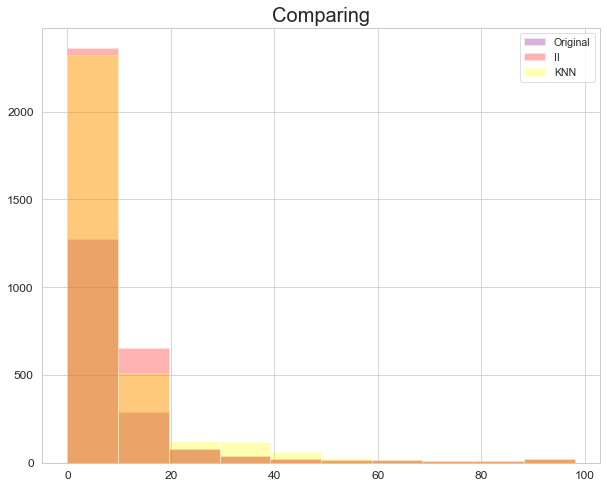

In [22]:
plt.figure(figsize = (10,8))
plt.hist(NCDB3.tumor_depth, facecolor = "purple", alpha = 0.3, label = "Original")
plt.hist(compare_imputed.IterativeImputer, facecolor = "red", alpha = 0.3, label = "II")
plt.hist(compare_imputed.KNNImputer,facecolor = "yellow", alpha = 0.3, label = "KNN")
plt.title("Comparing", size = 20)
plt.legend(loc = "upper right")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

#### something weird is happening in KNN?

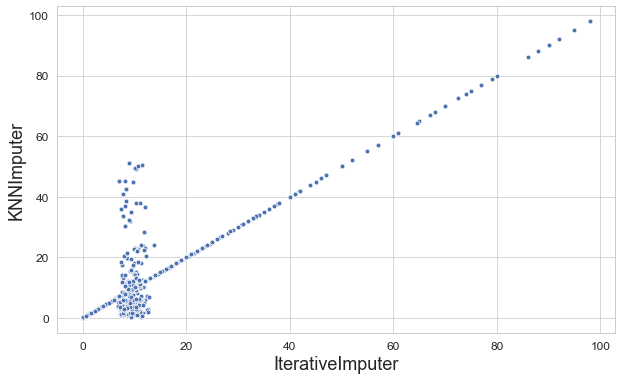

In [23]:
import seaborn as sns 
plt.figure(figsize = (10,6))
sns.scatterplot(data = compare_imputed, x = "IterativeImputer", y = "KNNImputer")
plt.xlabel("IterativeImputer", size = 18)
plt.ylabel ("KNNImputer",  size = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()